Lybraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from tensorflow import keras
import datetime

### EDA

In [3]:
train_path='data/test_motion_data.csv'
test_path='data/train_motion_data.csv'

#### Train data

In [4]:
train_data=pd.read_csv(train_path)
train_data.head(1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.758194,-0.217791,0.457263,0.0,0.0,0.0,AGGRESSIVE,818922


In [5]:
train_data.describe

<bound method NDFrame.describe of           AccX      AccY      AccZ     GyroX     GyroY     GyroZ       Class  \
0     0.758194 -0.217791  0.457263  0.000000  0.000000  0.000000  AGGRESSIVE   
1     0.667560 -0.038610  0.231416 -0.054367 -0.007712  0.225257  AGGRESSIVE   
2     2.724449 -7.584121  2.390926  0.023824  0.013668 -0.038026  AGGRESSIVE   
3     2.330950 -7.621754  2.529024  0.056810 -0.180587 -0.052076  AGGRESSIVE   
4     2.847215 -6.755621  2.224640 -0.031765 -0.035201  0.035277  AGGRESSIVE   
...        ...       ...       ...       ...       ...       ...         ...   
3079 -0.713858 -0.652975 -0.164015 -0.147829 -1.309466  0.517250        SLOW   
3080  1.514261  0.330070  1.020714  1.321302  1.707598 -0.674548        SLOW   
3081  1.280216 -1.735172 -2.332695  0.583376  0.690507 -0.468075        SLOW   
3082  0.912313  0.583314 -0.965622  0.235794  0.512745  0.406073        SLOW   
3083  1.462172  0.190287  0.019377 -0.254731 -0.279547  0.076205        SLOW   

     

In [6]:
train_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [7]:
train_data=train_data.sort_values(by='Timestamp')

In [8]:
train_data.Timestamp.unique().shape

(1667,)

There are roughly 2 measurements per second

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3084 entries, 0 to 3083
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3084 non-null   float64
 1   AccY       3084 non-null   float64
 2   AccZ       3084 non-null   float64
 3   GyroX      3084 non-null   float64
 4   GyroY      3084 non-null   float64
 5   GyroZ      3084 non-null   float64
 6   Class      3084 non-null   object 
 7   Timestamp  3084 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 216.8+ KB


In [10]:
train_data.Timestamp.value_counts().describe()

count    1667.000000
mean        1.850030
std         0.357149
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times.

In [11]:
train_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [12]:
train_data['Timestamp']=train_data['Timestamp'].astype('int')

train_data['Class']=train_data['Class'].astype('category')
train_data['class_code']=train_data['Class'].cat.codes

In [13]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

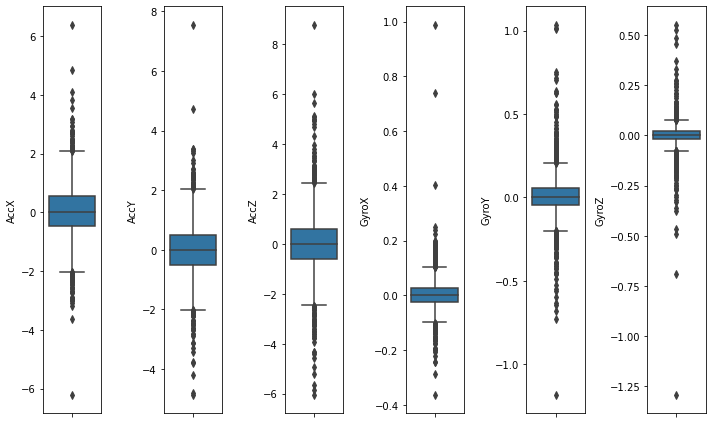

In [14]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

There are a lot of outliers, e.i., There is many measuments in the same timestamp that are desagreeing badly. However, it might be due to is amplitude. Then lets take a look in the boxplot normalized. 

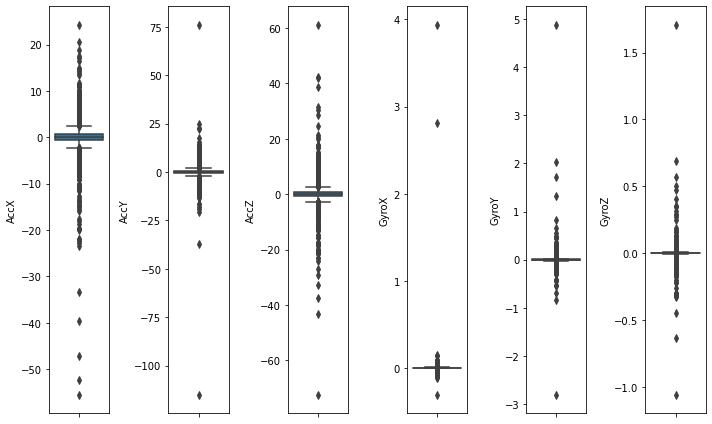

In [15]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

The gyroscope data is not desagreeing much. But, the accelaration that It massive desagreement in some measuments. 
 


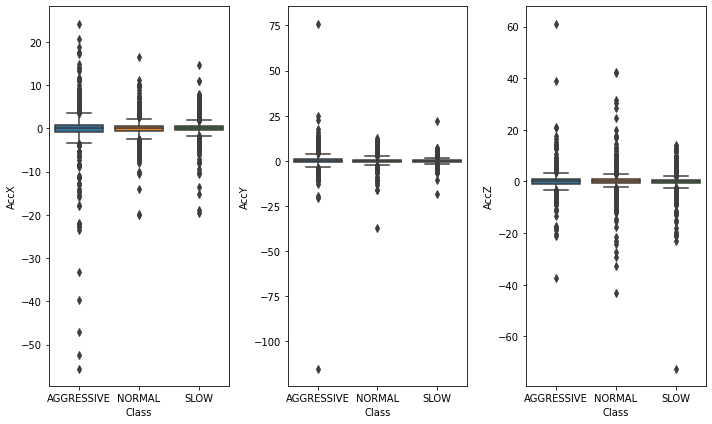

In [16]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(train_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


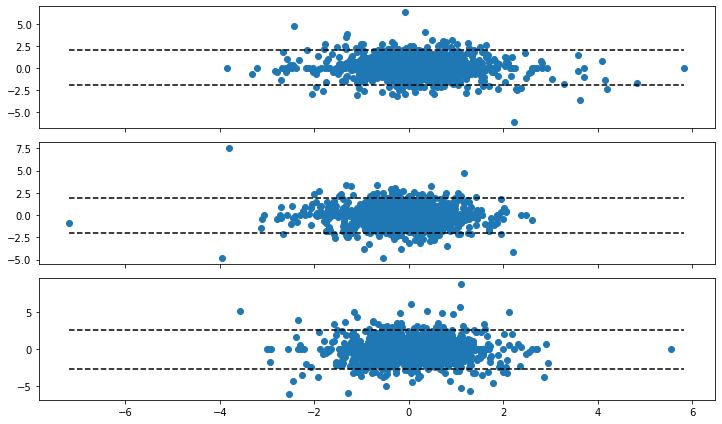

In [17]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


Even though, the data are quite odd and show significant different, Using [1] one might argui that both data agree.

Also, With this it seems that there is not a specific range where the data desagree more.

Since both measures may have differnt signs I will be taken the mean of its module, I wonder if there is some behaviour hidden due it. 

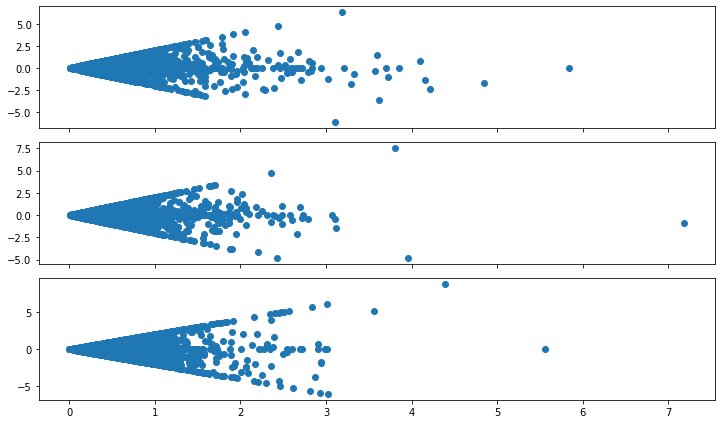

In [18]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [19]:
train_data['Acc_mod']=0.5*(train_data['AccX']**2+train_data['AccY']**2+train_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

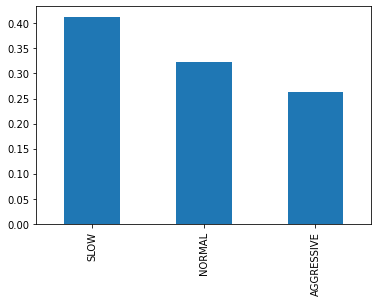

In [20]:
train_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [21]:
missing_seconds=set(train_data['Timestamp'].unique()).difference(set(range(train_data['Timestamp'].min(),train_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Bellow, it has been created some code for fixing some possible descontinuity

In [22]:
avaible_seconds=train_data.Timestamp.unique()

for second in missing_seconds:
    new_index=len(train_data)+1
    train_data.loc[new_index,['Timestamp']]=[second]
    train_data.loc[new_index,var_columns]=[np.nan]*len(var_columns)
   
    for offset in range(1,11):
        filled=False
        if second-offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second-offset,label_columns]
            filled=True
            break
        elif second+offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second+offset,label_columns]
            filled=True
            break

    if not filled: print('Method did not work')
    train_data.loc[new_index,label_columns]=[np.nan]*len(label_columns)
    
train_data=train_data.sort_values('Timestamp').reset_index(drop=True)
train_data[var_columns]=train_data[var_columns].interpolate(method='polynomial',order=5)[var_columns]=train_data[var_columns].interpolate(method='linear')

Observing the data as a signal

In [23]:
train_data['Class'].map({'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}).value_counts()

green    1273
blue      997
red       814
Name: Class, dtype: int64

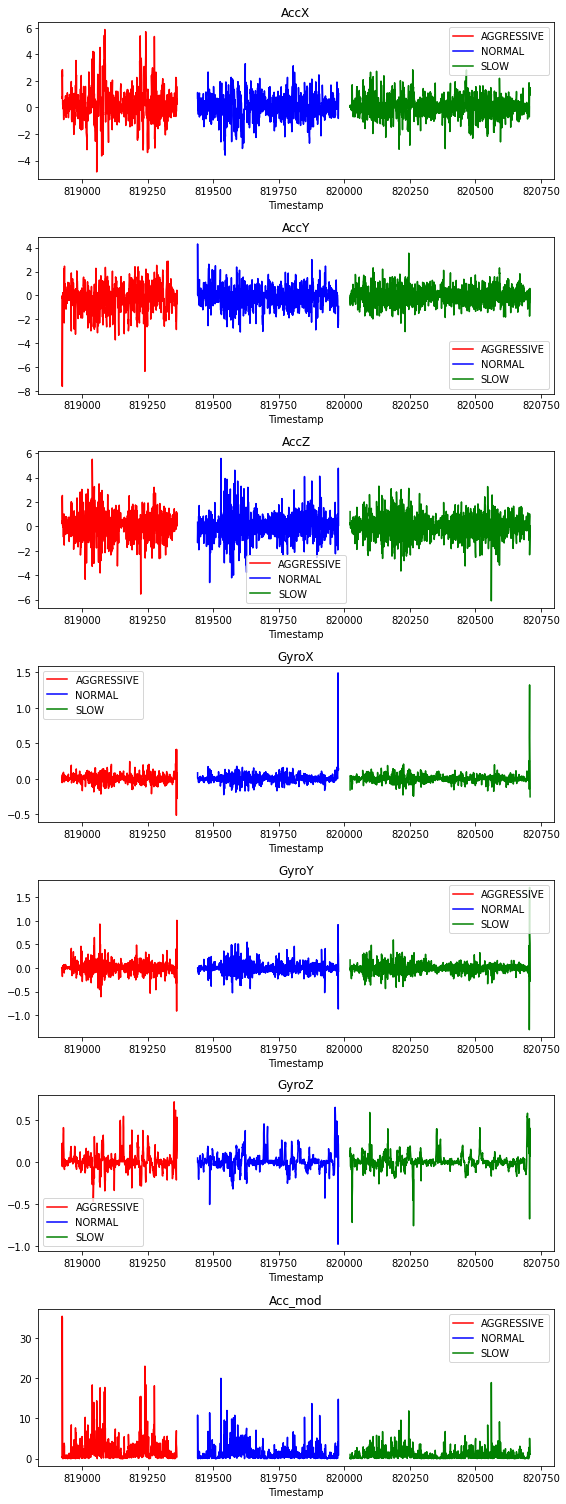

In [24]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=train_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

In [25]:
def fourier_analysis(data,fft_ax,psd_ax,prefix=''):
    fft=np.fft.fft(data)
    freq=np.fft.fftfreq(len(data),d=1)

    fft_ax.plot(freq,fft.real,color='red',alpha=0.5,label='real')
    fft_ax.plot(freq,fft.imag,color='blue',alpha=0.6,label='imag')
    fft_ax.set_xlim(left=0)
    fft_ax.set_title(prefix+' FFT')
    fft_ax.legend()
    psd=(1/len(data))*(fft.real**2+fft.imag**2)
    psd_ax.set_title(prefix+' PSD')
    psd_ax.plot(freq,psd,color='blue',alpha=0.7)
    psd_ax.set_xlim(left=-0.01)
    

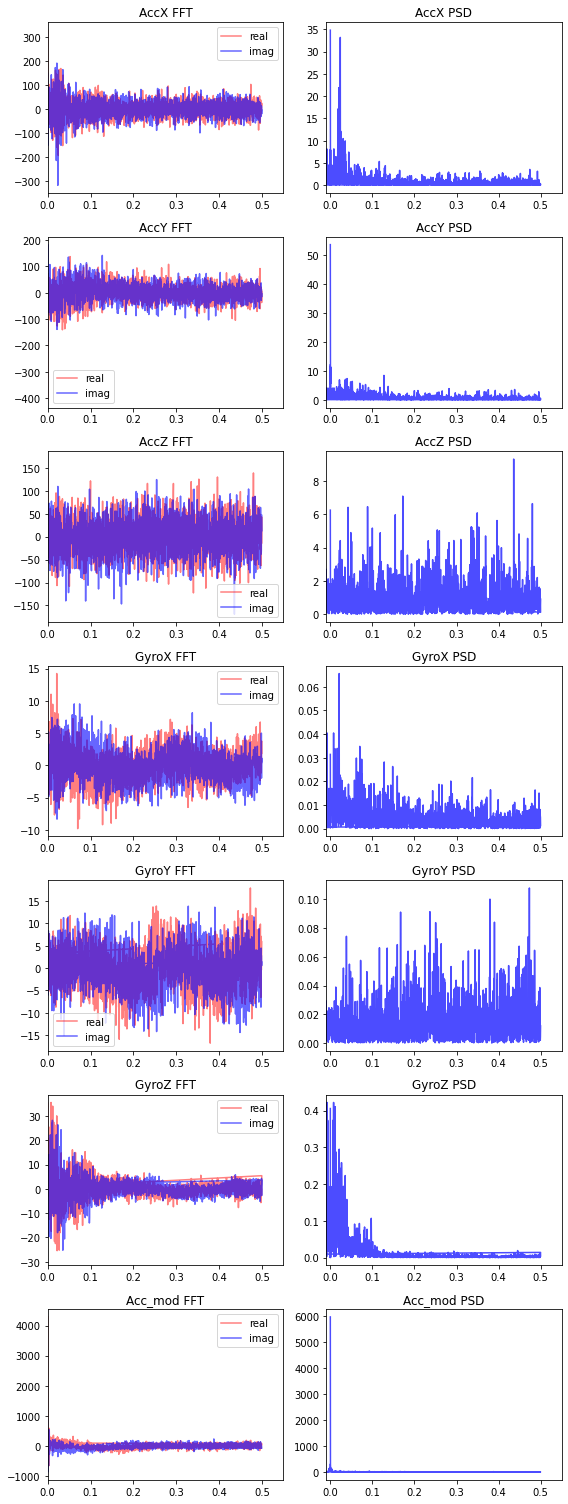

In [26]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(train_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

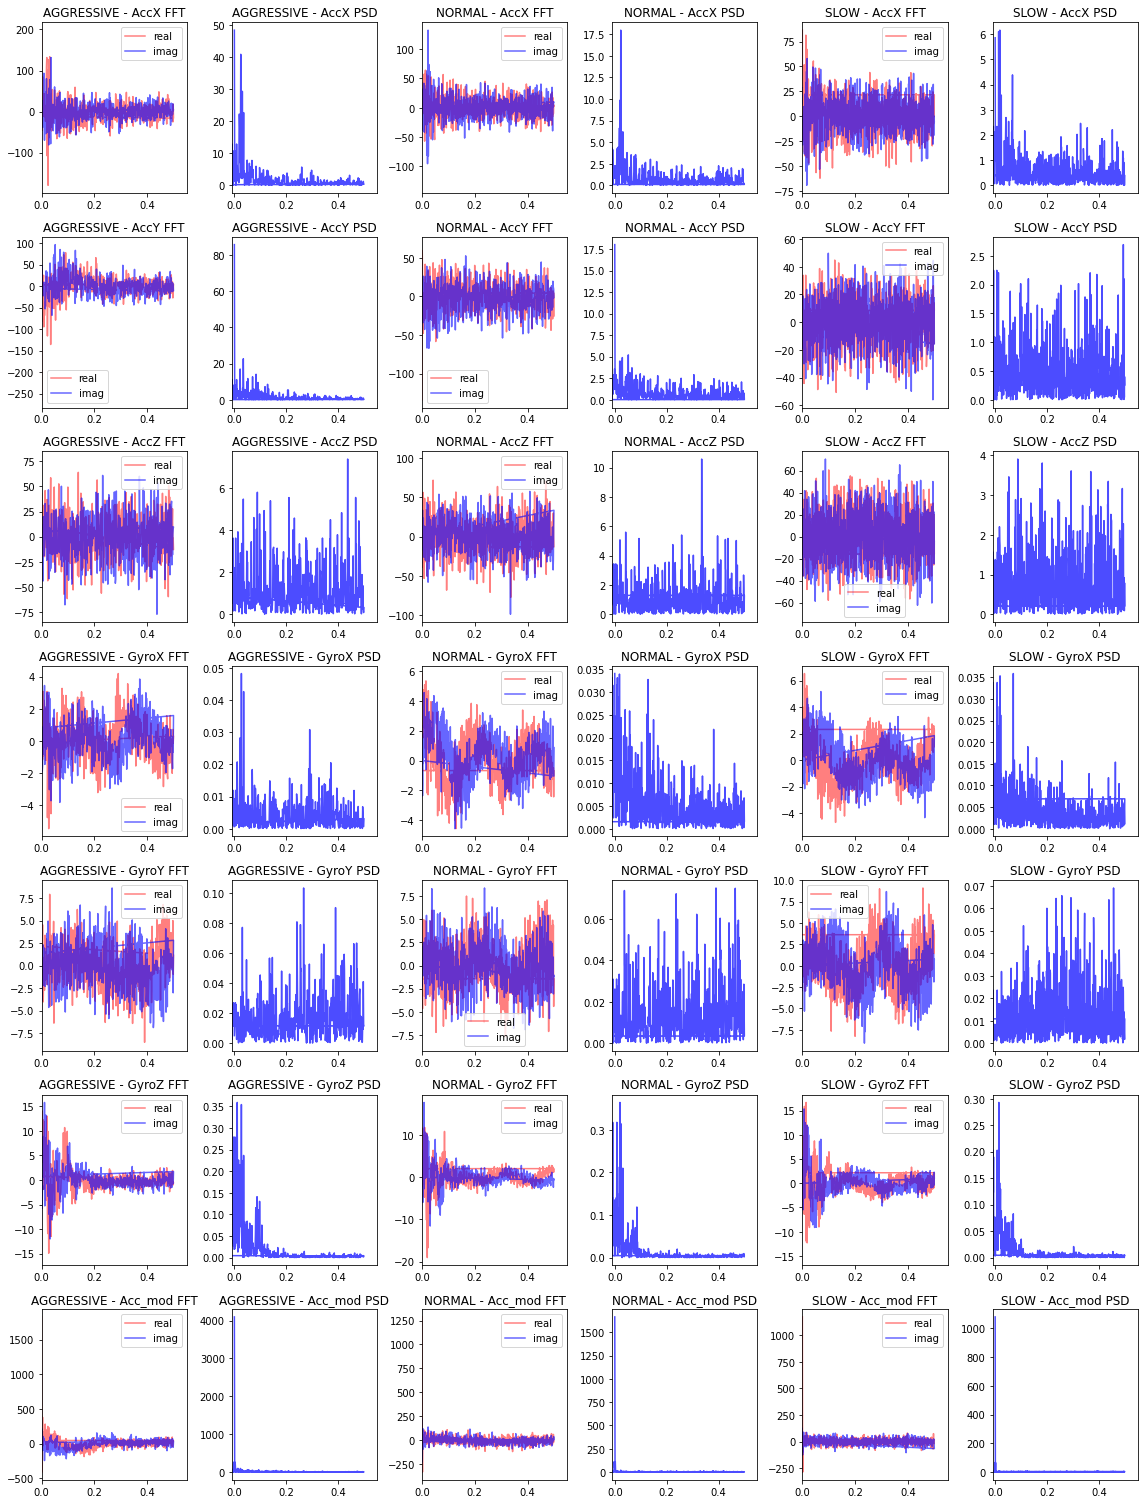

In [27]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [28]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

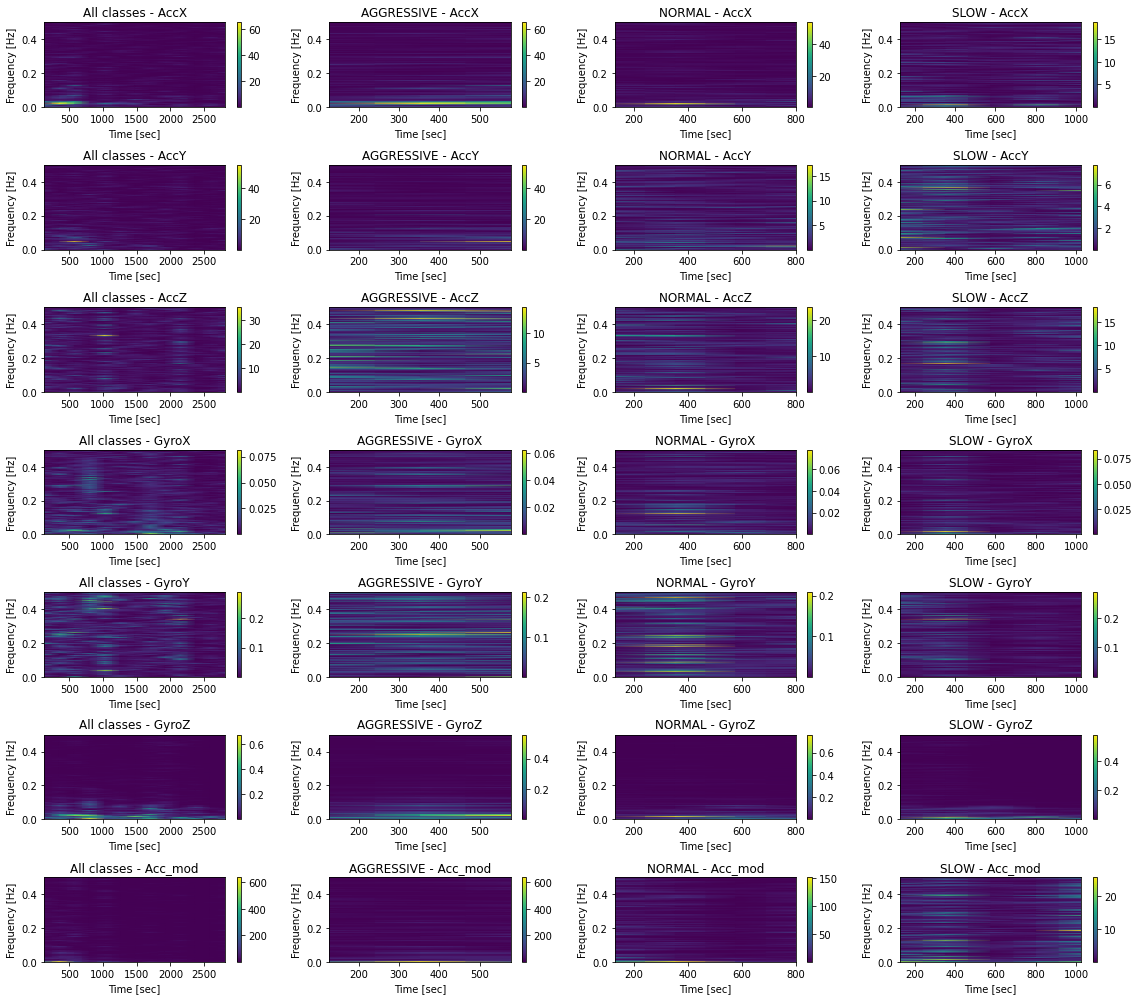

In [29]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=train_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

#### Test data - The previus analysys was replicated

In [30]:
test_data=pd.read_csv(test_path)
test_data.head(1)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.0,0.0,0.0,0.059407,-0.174707,0.101938,NORMAL,3581629


In [31]:
test_data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03
mean,0.040467,-0.073418,0.008271,0.001593,-0.001273,0.007949,3.582707e+06
std,0.985653,0.903408,0.985061,0.066918,0.126205,0.115687,6.421479e+02
min,-4.636523,-4.699795,-7.143998,-0.751822,-1.587028,-1.236468,3.581629e+06
25%,-0.550695,-0.592540,-0.558464,-0.028558,-0.053756,-0.029398,3.582121e+06
50%,0.003931,-0.080833,0.002262,0.001985,-0.001833,0.002978,3.582702e+06
75%,0.595987,0.452401,0.556157,0.031918,0.051313,0.040852,3.583270e+06
max,4.985548,4.245151,5.171739,0.849255,1.679879,1.190500,3.583791e+06


In [32]:
test_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [33]:
test_data=test_data.sort_values(by='Timestamp')

In [34]:
test_data.Timestamp.unique().shape

(1968,)

There are roughly 2 measurements per second

In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 256.2+ KB


In [36]:
test_data.Timestamp.value_counts().describe()

count    1968.000000
mean        1.851626
std         0.355561
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times.

In [37]:
test_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [38]:
test_data['Timestamp']=test_data['Timestamp'].astype('int')

test_data['Class']=test_data['Class'].astype('category')
test_data['class_code']=test_data['Class'].cat.codes

In [39]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

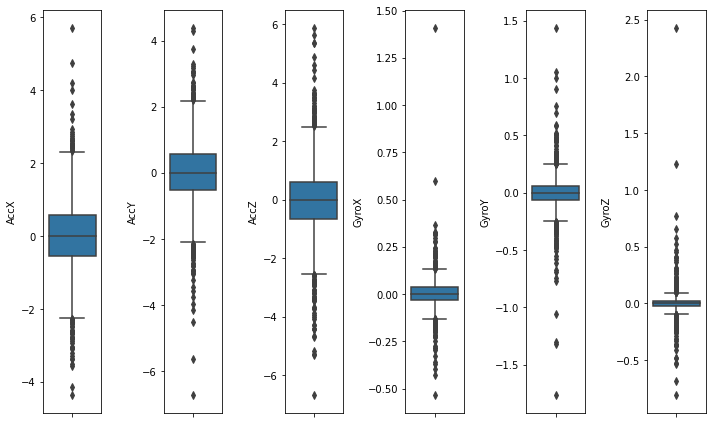

In [40]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

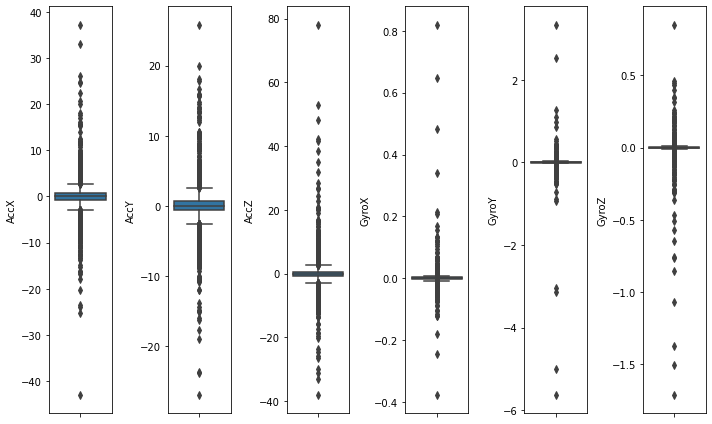

In [41]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

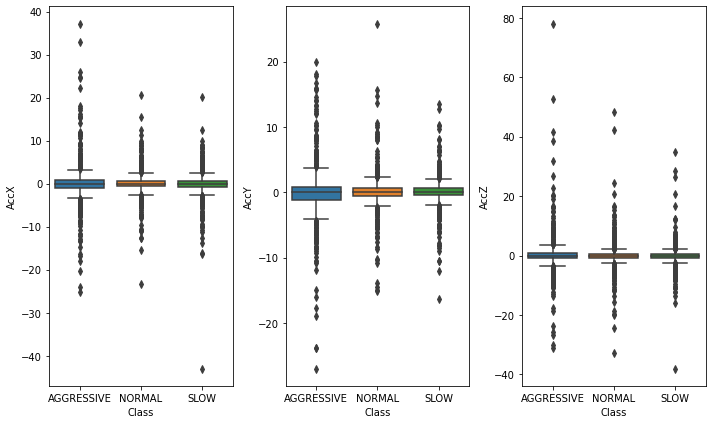

In [42]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(test_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


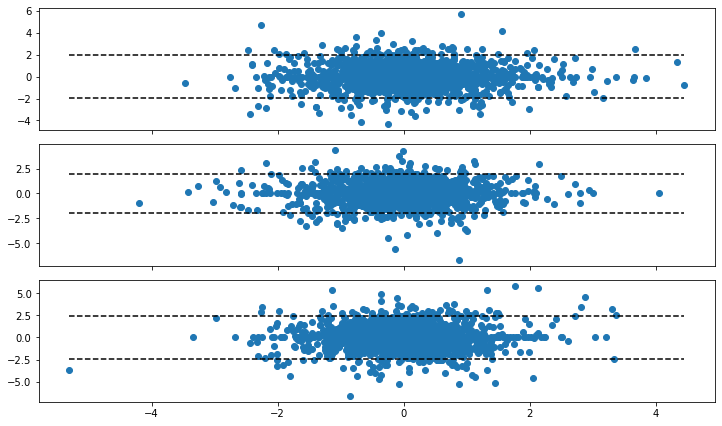

In [43]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


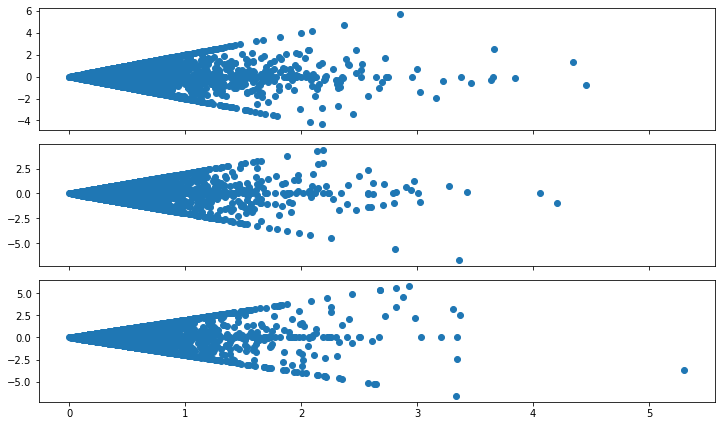

In [44]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [45]:
test_data['Acc_mod']=0.5*(test_data['AccX']**2+test_data['AccY']**2+test_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

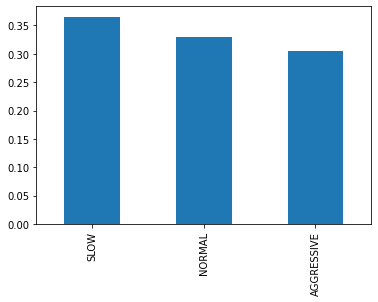

In [46]:
test_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [47]:
missing_seconds=set(test_data['Timestamp'].unique()).difference(set(range(test_data['Timestamp'].min(),test_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Observing the data as a signal

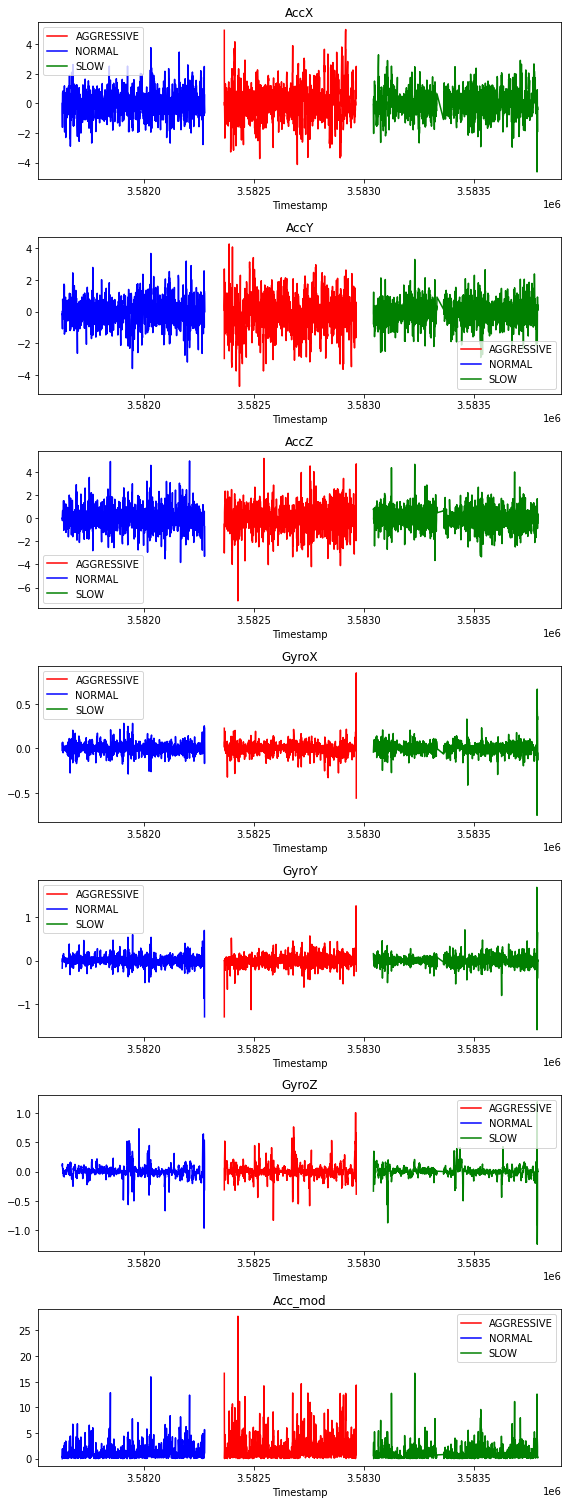

In [48]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=test_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

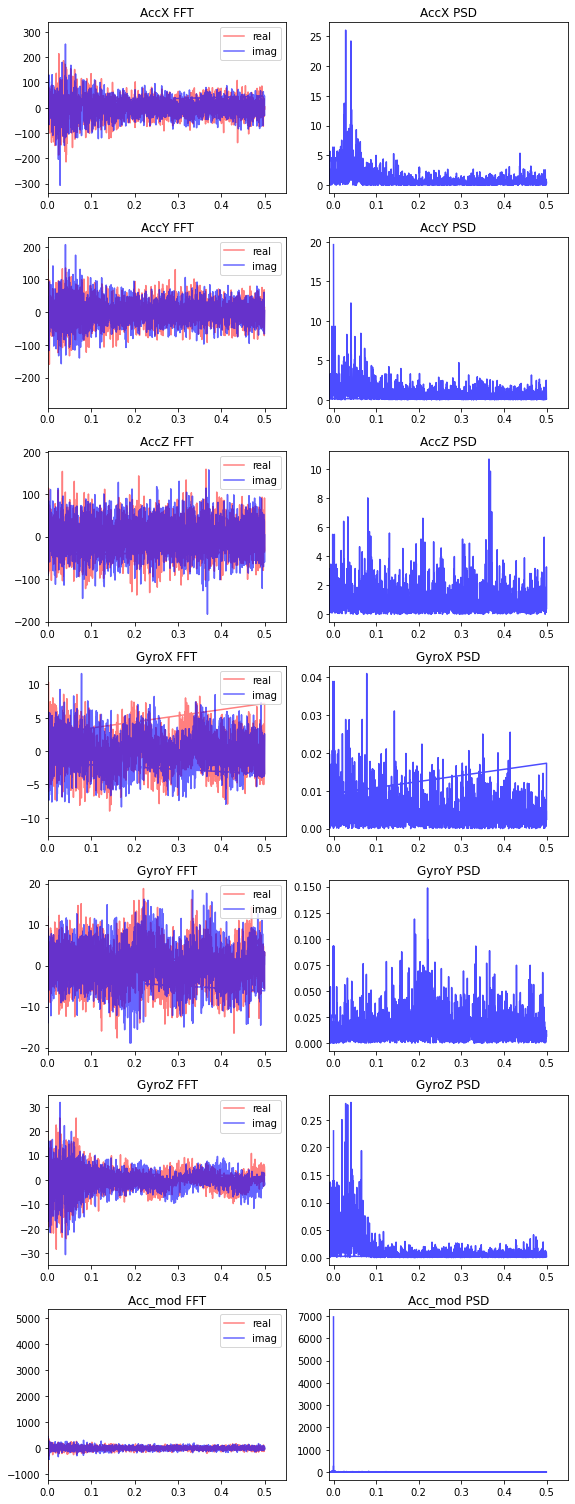

In [49]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(test_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

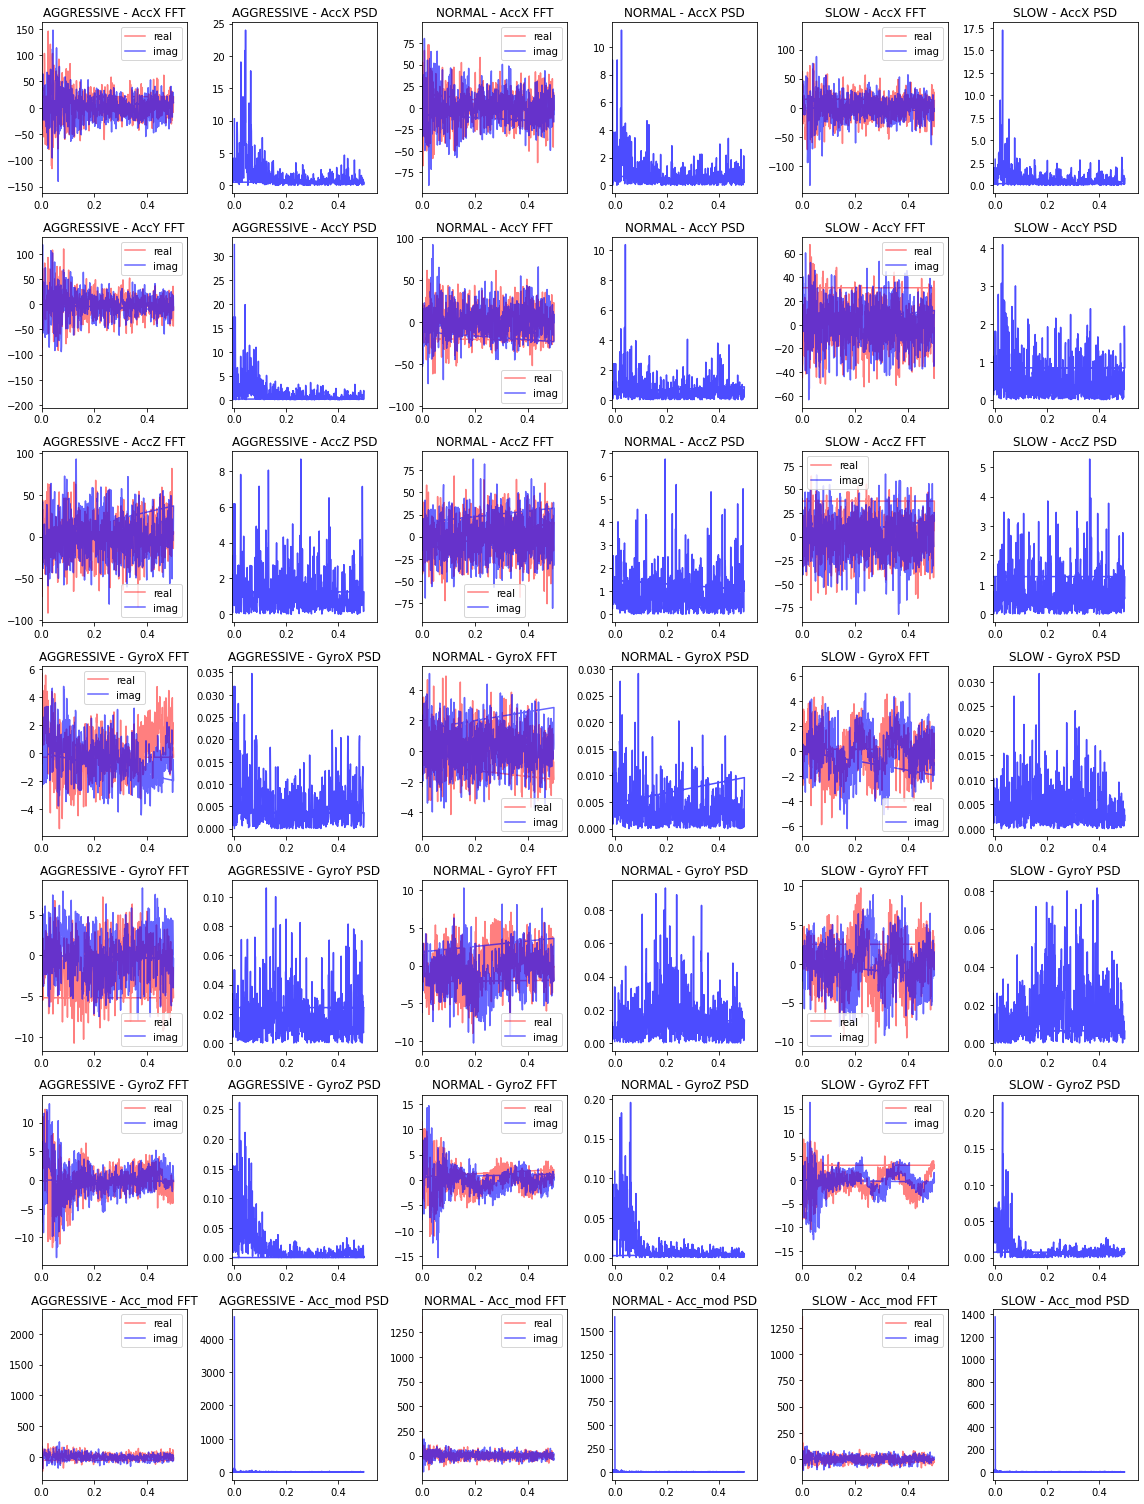

In [50]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [51]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

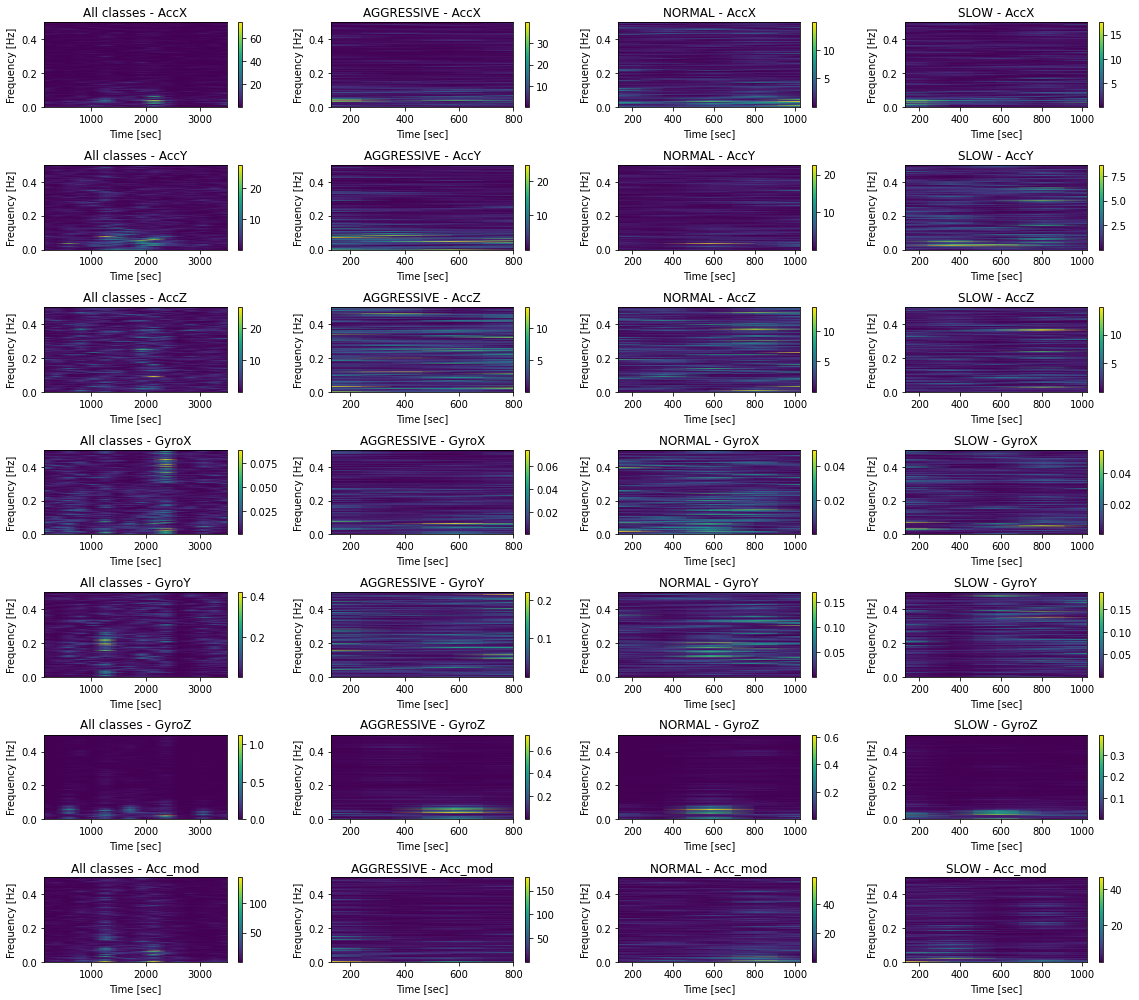

In [52]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=test_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

### Data processing to aplly AI

The models that will built aims to find which data are related to agressive driving, then, it will became a binary classification problem.

The input data should be a sequence of seconds, since the acceleration of a given seconds does not provide enough information about the driving beahaviour

In [53]:
test_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1331
1           NORMAL        1200
0           AGGRESSIVE    1113
dtype: int64

In [54]:
train_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1273
1           NORMAL         997
0           AGGRESSIVE     814
dtype: int64

In [55]:
map={0:1,2:0,1:0}
train_data.class_code=train_data.class_code.map(map)
test_data.class_code=test_data.class_code.map(map)

In [56]:
train_data['class_code'].value_counts()


0    2270
1     814
Name: class_code, dtype: int64

In [57]:
test_data['class_code'].value_counts()


0    2531
1    1113
Name: class_code, dtype: int64

In [58]:
def create_sequences(sequence_size,class_column,classes_key:list,df):
    X=[]
    Y=[]
    for key in classes_key:
        
        train_class=df[df[class_column]==key]    
        size=len(train_class)//sequence_size*sequence_size
        X_temp=train_class[var_columns.copy()].values[:size].reshape(-1,sequence_size,len(var_columns))
        Y_temp=np.array([key]*len(X_temp)).reshape(-1,1)
        if len(X)!=0:
            X=np.vstack((X,X_temp))
            Y=np.vstack((Y,Y_temp))
        else:
            X=X_temp
            Y=Y_temp
    return X,Y

In [59]:
X_train_sequece,Y_train_sequence=create_sequences(3,'class_code',[0,1,2],train_data)
X_test_sequence,Y_test_sequence=create_sequences(3,'class_code',[0,1,2],test_data)

In [60]:
np.random.seed(123)
X_test_sequence,X_val_sequence,Y_test_sequence,Y_val_sequence=train_test_split(X_test_sequence,Y_test_sequence,test_size=0.5,stratify=Y_test_sequence)

In [61]:
X_train=train_data[var_columns]
Y_train=train_data['class_code']
X_test=test_data[var_columns]
Y_test=test_data['class_code']
X_test,X_val,Y_test,Y_val=train_test_split(X_test,Y_test,test_size=0.5,stratify=Y_test)


In [62]:
sum(Y_train==1)

814

### Models

In [63]:
class ClassificationModel():
    def __init__(self,model,Xtrain,Ytrain,scaler=False,random_state=123,**kwargs):
        self.random_state=random_state
        if scaler:
            self.model=make_pipeline(StandardScaler(),model(**kwargs))
        else:
            self.model=model(**kwargs)
        self.Xtrain=Xtrain
        self.Ytrain=Ytrain
        self._get_label_proportion(Ytrain,prefix='train')
        
    
    def fit(self):      
        np.random.seed(self.random_state)  
        self.model.fit(self.Xtrain,self.Ytrain)

    def evaluate(self,Xtest,Ytest):
        self._get_label_proportion(Ytest,prefix='test')
        self.pred=self.model.predict(X_test)
        self._get_accuracy(Ytest)
        self._get_confusion_matrix(Ytest)
        self._get_class_report(Ytest)

    def _get_confusion_matrix(self,Ytest):
        cm = confusion_matrix(Ytest,self.pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
    
    def _get_class_report(self,Ytest):
        report=classification_report(Ytest,self.pred)
        print(report)

    def _get_accuracy(self,Ytest):
        accuracy=accuracy_score(Ytest,self.pred)
        print(f'The accuracy observed was {accuracy*100:.0f} %')
    
    def _get_label_proportion(self,Y,prefix=''):
        true_rate=sum(Y==1)/len(Y)
        print(f'{prefix}: The dataset has {true_rate*100:.0f}% of positive')
    

### Machine learning

Logistic Regression

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 68 %
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1265
           1       0.31      0.05      0.08       557

    accuracy                           0.68      1822
   macro avg       0.50      0.50      0.44      1822
weighted avg       0.58      0.68      0.58      1822



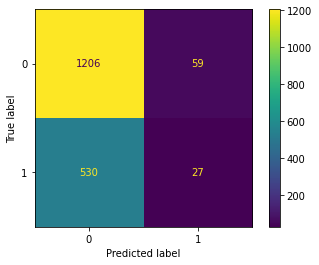

In [64]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,n_jobs=-1)
LR.fit()
LR.evaluate(X_val,Y_val)

Scaled

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 68 %
              precision    recall  f1-score   support

           0       0.70      0.95      0.80      1265
           1       0.32      0.05      0.09       557

    accuracy                           0.68      1822
   macro avg       0.51      0.50      0.45      1822
weighted avg       0.58      0.68      0.58      1822



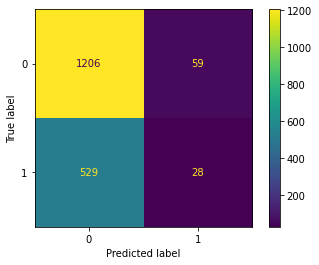

In [65]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,scaler=True)
LR.fit()
LR.evaluate(X_val,Y_val)

The dummiest classifier would guess everything negative and would have the same result.

SVM

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 67 %
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1265
           1       0.27      0.04      0.07       557

    accuracy                           0.67      1822
   macro avg       0.48      0.50      0.44      1822
weighted avg       0.56      0.67      0.58      1822



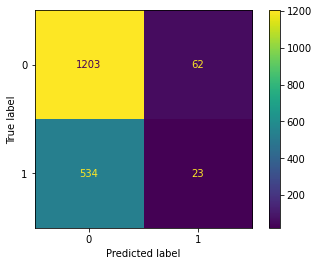

In [66]:
SVC_model=ClassificationModel(SVC,X_train,Y_train,scaler=True)
SVC_model.fit()
SVC_model.evaluate(X_val,Y_val)

Random Forest

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 66 %
              precision    recall  f1-score   support

           0       0.69      0.91      0.79      1265
           1       0.31      0.09      0.14       557

    accuracy                           0.66      1822
   macro avg       0.50      0.50      0.46      1822
weighted avg       0.58      0.66      0.59      1822



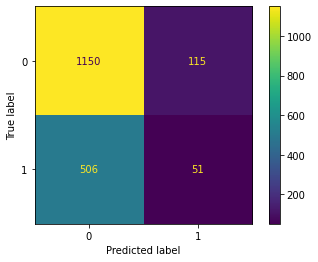

In [67]:
RF=ClassificationModel(RandomForestClassifier,X_train,Y_train,n_jobs=-1)
RF.fit()
RF.evaluate(X_val,Y_val)

Naive Bayes

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 63 %
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      1265
           1       0.28      0.13      0.17       557

    accuracy                           0.63      1822
   macro avg       0.49      0.49      0.47      1822
weighted avg       0.57      0.63      0.58      1822



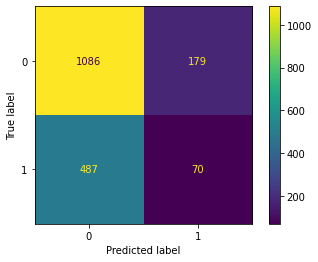

In [68]:
MB=ClassificationModel(GaussianNB,X_train,Y_train)
MB.fit()
MB.evaluate(X_val,Y_val)

Xgboost

train: The dataset has 26% of positive
test: The dataset has 31% of positive
The accuracy observed was 64 %
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1265
           1       0.31      0.15      0.20       557

    accuracy                           0.64      1822
   macro avg       0.50      0.50      0.48      1822
weighted avg       0.58      0.64      0.59      1822



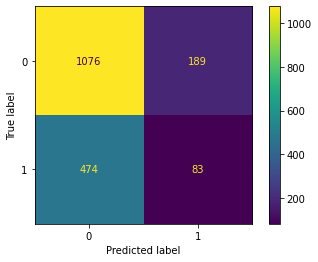

In [69]:
XGB=ClassificationModel(XGBClassifier,X_train,Y_train)
XGB.fit()
XGB.evaluate(X_val,Y_val)

None of the models have performed well, as it was mentioned before, our base line shloud be ~69%.

### Deep Learning

MLP

In [138]:
def _unpack_data_history(history_record,key):
    key=_get_metric_key_by_prefix(key,history_record)
    metric=[]
    for train_data in history_record:
        metric.extend(train_data.history[key])
    
    return metric

def _get_metric_key_by_prefix(key,history_record):
    key_in_history=''
    if 'val' in key:
        for metric in history_record[-1].history.keys():
            if key in metric:
                key_in_history=metric
                break
    else:
        for metric in history_record[-1].history.keys():
            if key in metric and 'val' not in metric:
                key_in_history=metric
                break

    return key_in_history

def loss_plot(history_record):
    loss=_unpack_data_history(history_record,'loss')
    plt.title('loss')
    plt.plot(loss)
    plt.xlabel('epochs')
    plt.show()

def accuracy_plot(history_record):
    accuracy=_unpack_data_history(history_record,'binary_accuracy')
    val_accuracy=_unpack_data_history(history_record,'val_binary_accuracy')
    plt.title('Accuracy')
    plt.plot(accuracy,label='train')
    plt.plot(val_accuracy,label='val')
    plt.legend()
    plt.xlabel('epochs')
    plt.grid(True)
    plt.show()



def precision_recall_plot(history_record):
    
    precision=_unpack_data_history(history_record,'precision')
    recall=_unpack_data_history(history_record,'recall')
    val_precision=_unpack_data_history(history_record,'val_precision')
    val_recall=_unpack_data_history(history_record,'val_recall')
    plt.subplot(1,2,1)
    plt.title('Precision')
    plt.plot(precision,label='Train')
    plt.plot(val_precision,label='Val') 
    plt.xlabel('epochs')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Recall')
    plt.plot(recall,label='Train')
    plt.plot(val_recall,label='Val') 
    plt.xlabel('epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_all_metrics(history_record):
    loss_plot(history_record)
    accuracy_plot(history_record)
    precision_recall_plot(history_record)



model 1

In [146]:
def model_1(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
        
            keras.Input(shape=(7,)),
            keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
            keras.layers.Dense(10,activation='tanh'),
            keras.layers.Dropout(0.4),    
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model

def training_params_1():
    epochs=300
    batch_size=32
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size}





In [147]:
np.random.seed(123)
MLP_model=model_1()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 10)                80        
                                                                 
 dense_201 (Dense)           (None, 10)                110       
                                                                 
 dropout_46 (Dropout)        (None, 10)                0         
                                                                 
 dense_202 (Dense)           (None, 6)                 66        
                                                                 
 dense_203 (Dense)           (None, 6)                 42        
                                                                 
 dense_204 (Dense)           (None, 1)                 7         
                                                                 
Total params: 305
Trainable params: 305
Non-trainable

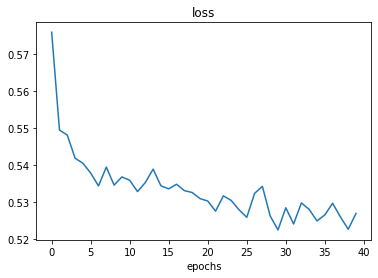

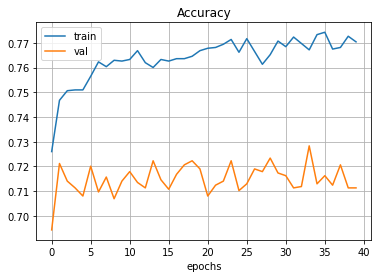

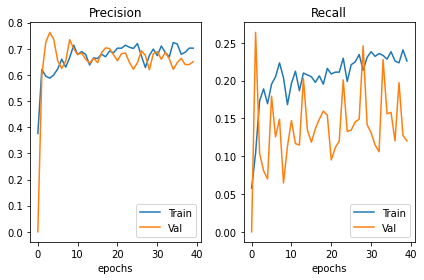

In [148]:
plot_all_metrics(MLP_model_history)

In [149]:

np.random.seed(321)
MLP_model=model_1(False)
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)

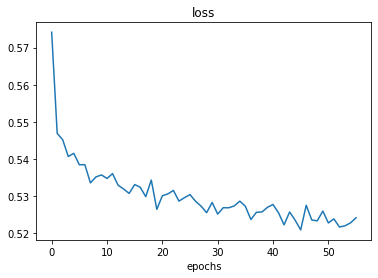

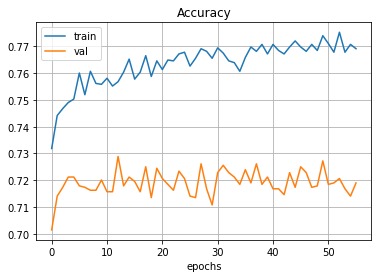

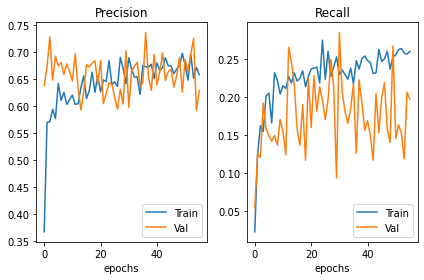

In [150]:
plot_all_metrics(MLP_model_history)

model 2

In [151]:
def model_2(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
            keras.Input(shape=(7,)),            
            keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(10,activation='tanh'),
            keras.layers.Dropout(0.4),    
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dropout(0.7),  
            keras.layers.Dense(10,activation='tanh'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model


In [152]:
np.random.seed(123)
MLP_model=model_2()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 10)                80        
                                                                 
 batch_normalization_13 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_211 (Dense)           (None, 10)                110       
                                                                 
 dropout_48 (Dropout)        (None, 10)                0         
                                                                 
 dense_212 (Dense)           (None, 6)                 66        
                                                                 
 dense_213 (Dense)           (None, 6)                 42        
                                                     

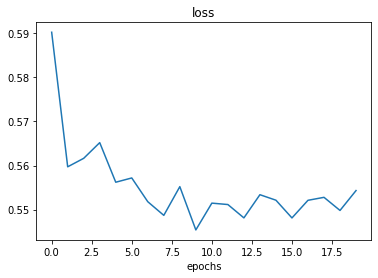

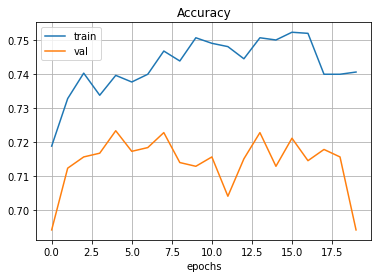

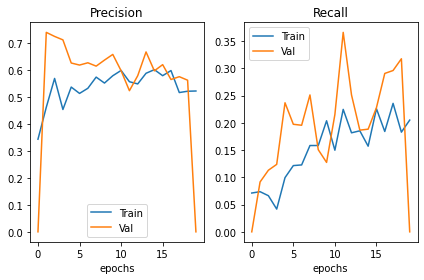

In [153]:
plot_all_metrics(MLP_model_history)

In [154]:
np.random.seed(321)
MLP_model=model_2()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 10)                80        
                                                                 
 batch_normalization_14 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_217 (Dense)           (None, 10)                110       
                                                                 
 dropout_50 (Dropout)        (None, 10)                0         
                                                                 
 dense_218 (Dense)           (None, 6)                 66        
                                                                 
 dense_219 (Dense)           (None, 6)                 42        
                                                     

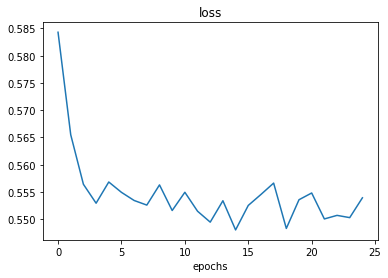

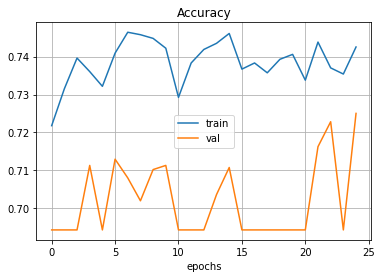

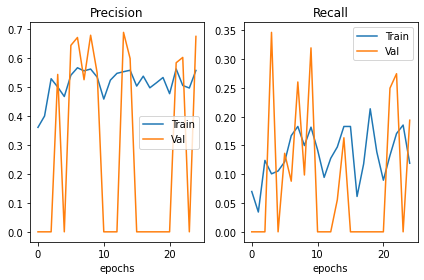

In [155]:
plot_all_metrics(MLP_model_history)

model 3

In [156]:
def model_3(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
            keras.Input(shape=(7,)),            
            keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(5,activation='tanh'),
            keras.layers.Dropout(0.4),    
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dropout(0.7),  
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(4,activation='tanh'),
            keras.layers.Dense(2,activation='tanh'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_15 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_223 (Dense)           (None, 5)                 30        
                                                                 
 dropout_52 (Dropout)        (None, 5)                 0         
                                                                 
 dense_224 (Dense)           (None, 3)                 18        
                                                                 
 dense_225 (Dense)           (None, 3)                 12        
                                                     

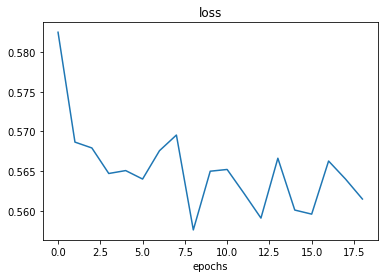

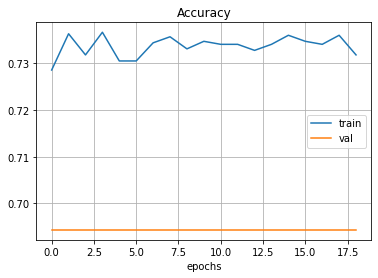

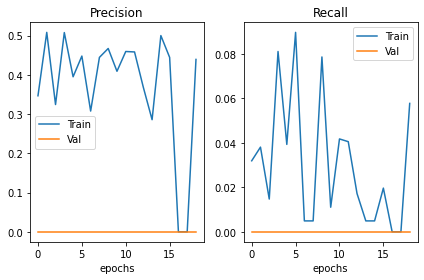

In [157]:
np.random.seed(312)
MLP_model=model_3()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)
plot_all_metrics(MLP_model_history)


model 4

In [158]:
def model_4(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
            keras.Input(shape=(7,)),            
            keras.layers.Dense(5,activation='selu', kernel_initializer="glorot_uniform"),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(5,activation='selu'),
            keras.layers.Dropout(0.4),    
            keras.layers.Dense(3,activation='selu'),
            keras.layers.Dense(3,activation='selu'),
            keras.layers.Dropout(0.7),  
            keras.layers.Dense(6,activation='selu'),
            keras.layers.Dense(4,activation='selu'),
            keras.layers.Dense(2,activation='selu'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_16 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_231 (Dense)           (None, 5)                 30        
                                                                 
 dropout_54 (Dropout)        (None, 5)                 0         
                                                                 
 dense_232 (Dense)           (None, 3)                 18        
                                                                 
 dense_233 (Dense)           (None, 3)                 12        
                                                     

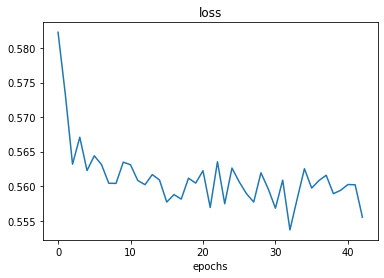

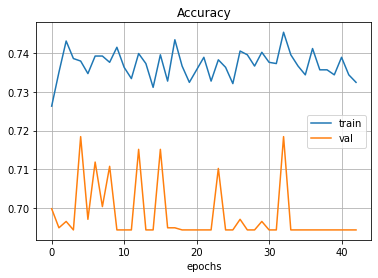

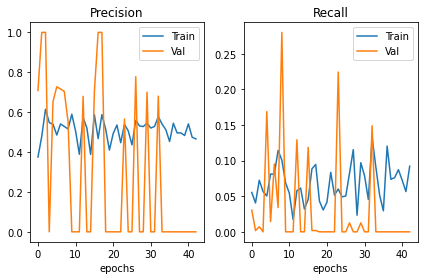

In [159]:
np.random.seed(312)
MLP_model=model_4()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)
plot_all_metrics(MLP_model_history)

model 5

In [160]:
def model_5(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
            keras.Input(shape=(7,)),            
            keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(5,activation='tanh'),
            keras.layers.Dropout(0.4),    
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dropout(0.7),  
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(4,activation='tanh'),
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(4,activation='tanh'),
            keras.layers.Dense(6,activation='tanh'),
            keras.layers.Dense(4,activation='tanh'),
            keras.layers.Dense(2,activation='tanh'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 5)                 40        
                                                                 
 batch_normalization_17 (Bat  (None, 5)                20        
 chNormalization)                                                
                                                                 
 dense_239 (Dense)           (None, 5)                 30        
                                                                 
 dropout_56 (Dropout)        (None, 5)                 0         
                                                                 
 dense_240 (Dense)           (None, 3)                 18        
                                                                 
 dense_241 (Dense)           (None, 3)                 12        
                                                     

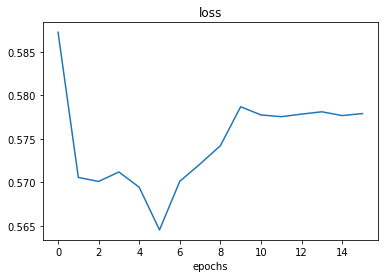

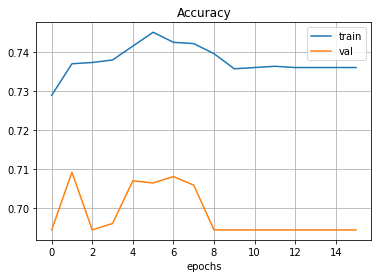

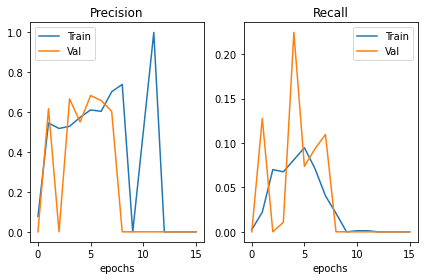

In [161]:
np.random.seed(312)
MLP_model=model_5()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)
plot_all_metrics(MLP_model_history)

model 6

In [162]:
def model_6(show_archtecture=True):
    MLP_model=keras.Sequential(
        [
            keras.Input(shape=(7,)),            
            keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dense(3,activation='tanh'),
            keras.layers.Dense(1,activation='sigmoid')
        ]
        )
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
    model_loss=keras.losses.BinaryCrossentropy()
    model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
    model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
    MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
    if show_archtecture:
        MLP_model.summary()
    return MLP_model

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_250 (Dense)           (None, 5)                 40        
                                                                 
 dense_251 (Dense)           (None, 3)                 18        
                                                                 
 dense_252 (Dense)           (None, 3)                 12        
                                                                 
 dense_253 (Dense)           (None, 1)                 4         
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


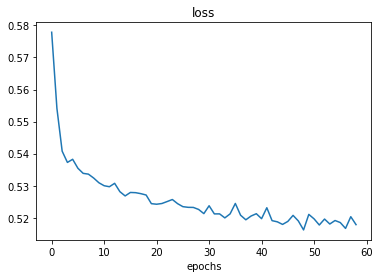

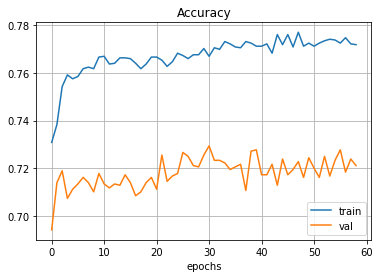

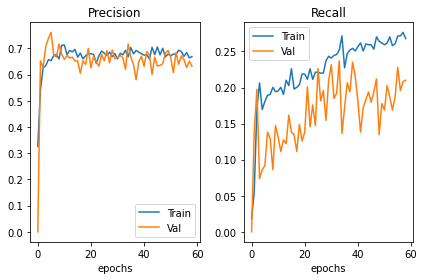

In [163]:
np.random.seed(312)
MLP_model=model_6()
MLP_model_history=[]
history_temp=MLP_model.fit(X_train,Y_train,validation_data=(X_val,Y_val),verbose=0,**training_params_1())
MLP_model_history.append(history_temp)
plot_all_metrics(MLP_model_history)

In [164]:
%load_ext tensorboard
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


CNN

RNN